In [3]:
# %pip install -q -U google-generativeai
# %pip install --upgrade google-generativeai
# %pip install openai python-dotenv numpy

<div style="max-width:880px;margin:12px auto;font-family:Inter, Poppins, system-ui, -apple-system, 'Segoe UI', Roboto, Arial;">
  <div style="border-radius:18px;overflow:hidden;padding:18px;background:linear-gradient(180deg, rgba(255,255,255,0.02), rgba(255,255,255,0.01));box-shadow:0 12px 40px rgba(2,6,23,0.6);border:1px solid rgba(255,255,255,0.04)">
    <div style="display:flex;align-items:center;gap:14px">
      <div style="width:64px;height:64px;border-radius:14px;background:linear-gradient(135deg,#ffd36b,#ff7aa2);display:flex;align-items:center;justify-content:center;font-weight:800;color:#081226;font-size:20px">R</div>
      <div>
        <div style="font-weight:800;font-size:20px;color:#f8fcff">What is RAG</div>
        <div style="color:rgba(255,255,255,0.78);font-size:13px;margin-top:4px">Retrieval-Augmented Generation explained</div>
      </div>
    </div>
    <div style="margin-top:14px;color:#eef7ff;line-height:1.5">
      <p><strong style="color:#fff">RAG</strong> stands for <strong>Retrieval-Augmented Generation</strong>.</p>
      <p>It is a technique used in Artificial Intelligence to improve the accuracy and reliability of Large Language Models (LLMs) like GPT-4 or Claude. In simple terms, RAG allows an AI to "cheat" by looking up information in a trusted textbook or database before answering your question, rather than relying solely on its memory.</p>
      <h4 style="margin-top:12px;color:#ffefc2">Why do we need it?</h4>
      <div style="padding-left:8px;color:rgba(255,255,255,0.9)">
        <ol>
          <li><strong>They are frozen in time:</strong> They don't know about events after training.</li>
          <li><strong>They hallucinate:</strong> If unsure, they may invent answers.</li>
          <li><strong>They lack private knowledge:</strong> They don't know internal company data.</li>
        </ol>
      </div>
      <h4 style="margin-top:8px;color:#cbe7ff">How RAG Works</h4>
      <div style="padding-left:8px;color:rgba(255,255,255,0.9)">
        <ol>
          <li><strong>Retrieval:</strong> Search a database for documents relevant to the query.</li>
          <li><strong>Augmentation:</strong> Combine retrieved facts with the user question.</li>
          <li><strong>Generation:</strong> The LLM generates the final answer using both its model and the retrieved facts.</li>
        </ol>
      </div>
      <h4 style="margin-top:8px;color:#d7ffcf">The Benefits</h4>
      <ul style="color:rgba(255,255,255,0.95)">
        <li><strong>Up-to-Date info:</strong> Update docs rather than retrain the model.</li>
        <li><strong>Fewer Lies:</strong> Grounding reduces hallucination.</li>
        <li><strong>Source Citing:</strong> You can verify documents used for answers.</li>
      </ul>
    </div>
  </div>
</div>


<div style="text-align:center;">
  <h3 style="
    font-family:Poppins, Inter, system-ui;
    font-size:30px;
    font-weight:700;
    color:#fff;
    text-shadow:
      0 0 8px rgba(123,108,255,0.8),
      0 0 14px rgba(255,122,162,0.6),
      0 0 22px rgba(255,211,107,0.5);
    letter-spacing:1px;
    margin:12px 0;
  ">Naive RAG</h3>
</div>


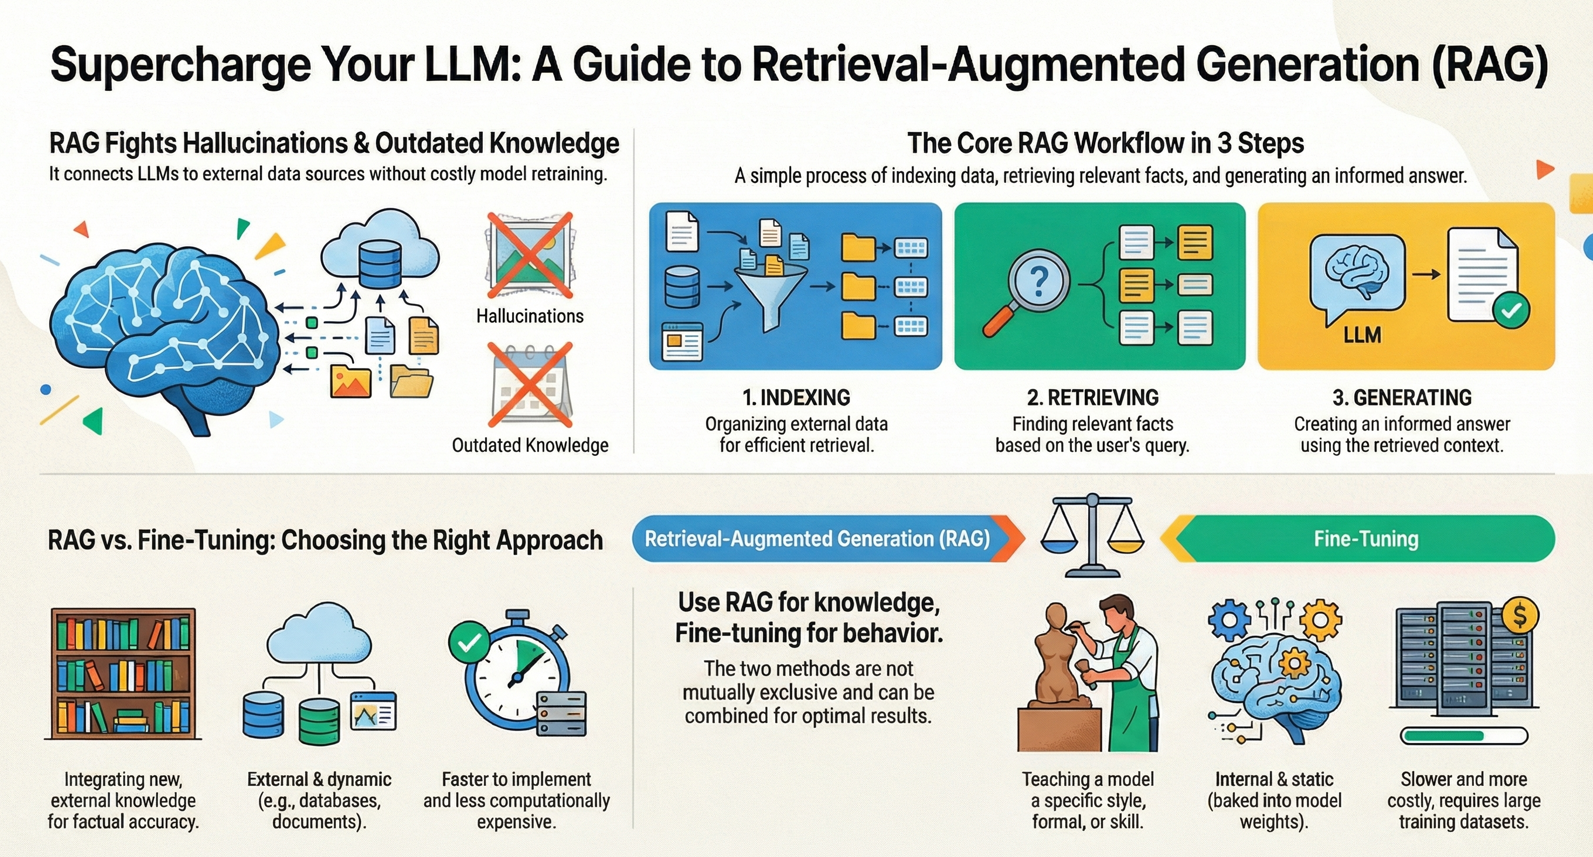

In [1]:
import os
import json
import numpy as np
import re
from collections import defaultdict
from dotenv import load_dotenv
from openai import AzureOpenAI
from IPython.display import display, Markdown
os.environ["OTEL_SDK_DISABLED"] = "true"
os.environ["LANGFUSE_SDK_DISABLED"] = "true"
os.environ["LANGFUSE_ENABLED"] = "false"
load_dotenv()

llm_client = AzureOpenAI(
    api_key=os.getenv("AZURE_GPT_4o_API_KEY"),
    api_version=os.getenv("AZURE_GPT_4o_API_VERSION"),
    azure_endpoint=os.getenv("AZURE_GPT_4o_ENDPOINT")
)

embed_client = AzureOpenAI(
    api_key=os.getenv("embedding_api_key"),
    api_version=os.getenv("embedding_api_version"),
    azure_endpoint=os.getenv("embedding_endpoint_url")
)
GPT_DEPLOYMENT = os.getenv("AZURE_DEPLOYMENT_GPT_4o")
EMBED_MODEL = os.getenv("embedding_model_name")

def get_embedding(text):
    """Helper to get vector from Azure."""
    clean_text = text.replace("\n", " ")
    return embed_client.embeddings.create(input=[clean_text], model=EMBED_MODEL).data[0].embedding

print("✅ Advanced RAG Training Environment Ready.")
print(f"   - Reasoning Engine: {GPT_DEPLOYMENT}")
print(f"   - Embedding Engine: {EMBED_MODEL}")


✅ Advanced RAG Training Environment Ready.
   - Reasoning Engine: gpt-4o
   - Embedding Engine: text-embedding-ada-002


<div style="text-align:center;">
    <img src="NaiveRAG.png" width="600">
</div>


#### **Data Ingestion**

- **Concept**: Before we can search, we need data. In Naive RAG, we take documents and slice them into "Chunks".
- **Critical Detail**: Watch how we deliberately introduce a "Fragmentation" issue here. We will split a cohesive fact into two separate chunks to prove a disadvantage later.

In [2]:
raw_knowledge_base = [
    "Naive RAG is the simplest retrieval architecture. It follows a 'Retrieve-Read' process.",
    "A major limitation of Naive RAG is 'Context Fragmentation'. This happens when...",
    "...a logical fact is cut in half by fixed-size chunking, causing the AI to lose the full picture.",
    "The 'Apple' is a fruit that is red and delicious. It is not a technology company.",
    "The support email for the RAG project is help@architect.com."
]

print(f"📚 Knowledge Base Loaded: {len(raw_knowledge_base)} chunks ready for indexing.")

📚 Knowledge Base Loaded: 5 chunks ready for indexing.


#### **Creating Embeddings**

- **Concept**: Computers don't understand text; they understand numbers. We use text-embedding-ada-002 to turn text into a list of floating-point numbers.
- **Visual**: We will inspect exactly what an "Index" looks like.

In [3]:
def get_embedding(text):
    response = embed_client.embeddings.create(
        input=text,
        model=os.getenv("embedding_model_name")
    )
    return response.data[0].embedding

# The Vector Store is a list of dictionaries in memory
vector_index = []

print("⚙️ STARTING INDEXING PROCESS...\n")

for i, text in enumerate(raw_knowledge_base):
    vector = get_embedding(text)
    doc_profile = {
        "id": i,
        "text": text,
        "vector": vector,  
        "vector_preview": vector[:5] 
    }
    vector_index.append(doc_profile)
    
    print(f"Chunk {i} Processed:")
    print(f"   Text: '{text[:50]}...'")
    print(f"   Vector Representation (First 5 dims): {vector[:5]}... (Total Dims: {len(vector)})")
    print("-" * 50)

print("\n✅ Indexing Complete. Total Chunks Indexed:", len(vector_index))

⚙️ STARTING INDEXING PROCESS...

Chunk 0 Processed:
   Text: 'Naive RAG is the simplest retrieval architecture. ...'
   Vector Representation (First 5 dims): [-0.02674783766269684, 0.018976688385009766, 0.003518566256389022, -0.012269526720046997, -0.0030825333669781685]... (Total Dims: 1536)
--------------------------------------------------
Chunk 1 Processed:
   Text: 'A major limitation of Naive RAG is 'Context Fragme...'
   Vector Representation (First 5 dims): [0.0014122845605015755, 0.0038400888442993164, 0.012616961263120174, -0.012040451169013977, 0.00076412467751652]... (Total Dims: 1536)
--------------------------------------------------
Chunk 2 Processed:
   Text: '...a logical fact is cut in half by fixed-size chu...'
   Vector Representation (First 5 dims): [-0.0013353590620681643, -0.0021262189839035273, 0.035916898399591446, -0.0054683745838701725, -0.02064420096576214]... (Total Dims: 1536)
--------------------------------------------------
Chunk 3 Processed:
   Text: '

#### **Search & Math**

- **Concept:** How do we find the right chunk? We don't use keywords. We use **Cosine Similarity**.
- **The Math:** $Similarity = (A \cdot B) / (||A|| \cdot ||B||)$


In [4]:
def cosine_similarity(v1, v2):
    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

def retrieve_and_inspect(query, top_k=2):
    print(f"\n🔍 PROCESSING QUERY: '{query}'")
    query_vector = get_embedding(query)
    print(f"   -> Query converted to vector: {query_vector[:5]}...")
    scored_results = []
    print("\n   📊 SCORING CANDIDATES (The 'Wide Net'):")
    print(f"   {'ID':<5} | {'Score':<10} | {'Text Snippet'}")
    print("   " + "-"*50)
    
    for doc in vector_index:
        score = cosine_similarity(query_vector, doc['vector'])
        scored_results.append((score, doc))
        snippet = doc['text'][:40].replace('\n', ' ') + "..."
        print(f"   {doc['id']:<5} | {score:.4f}     | {snippet}")

    scored_results.sort(key=lambda x: x[0], reverse=True)
    top_results = scored_results[:top_k]
    
    print(f"\n   🏆 WINNING CHUNKS (Top {top_k}):")
    for score, doc in top_results:
        print(f"      - [Score: {score:.4f}] {doc['text']}")
        
    return [doc['text'] for _, doc in top_results]

In [5]:
def run_naive_rag_simulation(query):
    retrieved_texts = retrieve_and_inspect(query, top_k=2)
    context_block = "\n".join([f"- {txt}" for txt in retrieved_texts])
    
    system_instruction = "You are an assistant. Answer STRICTLY using the provided Context. If the answer is not in the context, say 'I don't know'."
    
    final_prompt = f"""
    CONTEXT:
    {context_block}
    
    USER QUESTION:
    {query}
    """
    print("\n📨 PAYLOAD TO LLM (What GPT-4o actually sees):")
    print("="*60)
    print(f"[SYSTEM]: {system_instruction}")
    print(f"[USER]: {final_prompt}")
    print("="*60)

    response = llm_client.chat.completions.create(
        model=os.getenv("AZURE_DEPLOYMENT_GPT_4o"),
        messages=[
            {"role": "system", "content": system_instruction},
            {"role": "user", "content": final_prompt}
        ],
        temperature=0
    )
    
    answer = response.choices[0].message.content

    display(Markdown(f"### 🤖 GENERATED ANSWER:\n**{answer}**"))
    
    print("\n" + "#"*60)
    print("🤔 CRITICAL ANALYSIS (Why Naive RAG might fail here):")
    print("1. Did we retrieve the right chunk? Look at the Scores above.")
    print("2. Context Fragmentation: Did the answer require info from a chunk that wasn't retrieved?")
    print("3. Internal Knowledge: Did the LLM answer using the context, or did it hallucinate?")
    print("#"*60 + "\n")

# --- EXAMPLES ---

# TEST 1: The Ideal Scenario 
run_naive_rag_simulation("What is the support email?")

# TEST 2: The Failure Mode 
run_naive_rag_simulation("Explain why context fragmentation is a limitation.")

# TEST 3: The "Semantic Dissonance" Trap
run_naive_rag_simulation("Tell me about Apple technology.")


🔍 PROCESSING QUERY: 'What is the support email?'
   -> Query converted to vector: [0.00023735270951874554, -0.010622824542224407, 0.01603669673204422, -0.032126277685165405, -0.02083580754697323]...

   📊 SCORING CANDIDATES (The 'Wide Net'):
   ID    | Score      | Text Snippet
   --------------------------------------------------
   0     | 0.7081     | Naive RAG is the simplest retrieval arch...
   1     | 0.7009     | A major limitation of Naive RAG is 'Cont...
   2     | 0.6892     | ...a logical fact is cut in half by fixe...
   3     | 0.6984     | The 'Apple' is a fruit that is red and d...
   4     | 0.8529     | The support email for the RAG project is...

   🏆 WINNING CHUNKS (Top 2):
      - [Score: 0.8529] The support email for the RAG project is help@architect.com.
      - [Score: 0.7081] Naive RAG is the simplest retrieval architecture. It follows a 'Retrieve-Read' process.

📨 PAYLOAD TO LLM (What GPT-4o actually sees):
[SYSTEM]: You are an assistant. Answer STRICTLY usin

### 🤖 GENERATED ANSWER:
**The support email for the RAG project is help@architect.com.**


############################################################
🤔 CRITICAL ANALYSIS (Why Naive RAG might fail here):
1. Did we retrieve the right chunk? Look at the Scores above.
2. Context Fragmentation: Did the answer require info from a chunk that wasn't retrieved?
3. Internal Knowledge: Did the LLM answer using the context, or did it hallucinate?
############################################################


🔍 PROCESSING QUERY: 'Explain why context fragmentation is a limitation.'
   -> Query converted to vector: [0.019057178869843483, 0.0016983828973025084, 0.004991650581359863, -0.028830090537667274, -0.0036037613172084093]...

   📊 SCORING CANDIDATES (The 'Wide Net'):
   ID    | Score      | Text Snippet
   --------------------------------------------------
   0     | 0.7377     | Naive RAG is the simplest retrieval arch...
   1     | 0.8905     | A major limitation of Naive RAG is 'Cont...
   2     | 0.8014     | ...a logical fact is cut in half by fixe...
   3     | 0.6929     | 

### 🤖 GENERATED ANSWER:
**Context fragmentation is a limitation because it occurs when a logical fact is split into separate chunks due to fixed-size chunking. This prevents the AI from accessing the full picture of the information, leading to incomplete or inaccurate understanding and responses.**


############################################################
🤔 CRITICAL ANALYSIS (Why Naive RAG might fail here):
1. Did we retrieve the right chunk? Look at the Scores above.
2. Context Fragmentation: Did the answer require info from a chunk that wasn't retrieved?
3. Internal Knowledge: Did the LLM answer using the context, or did it hallucinate?
############################################################


🔍 PROCESSING QUERY: 'Tell me about Apple technology.'
   -> Query converted to vector: [0.0044790152460336685, 0.0022509756963700056, 0.022214869037270546, -0.023643435910344124, 0.013499299995601177]...

   📊 SCORING CANDIDATES (The 'Wide Net'):
   ID    | Score      | Text Snippet
   --------------------------------------------------
   0     | 0.7371     | Naive RAG is the simplest retrieval arch...
   1     | 0.7105     | A major limitation of Naive RAG is 'Cont...
   2     | 0.7378     | ...a logical fact is cut in half by fixe...
   3     | 0.8531     | The 'Apple' is a fru

### 🤖 GENERATED ANSWER:
**I don't know.**


############################################################
🤔 CRITICAL ANALYSIS (Why Naive RAG might fail here):
1. Did we retrieve the right chunk? Look at the Scores above.
2. Context Fragmentation: Did the answer require info from a chunk that wasn't retrieved?
3. Internal Knowledge: Did the LLM answer using the context, or did it hallucinate?
############################################################



---

<div style="text-align:center;">
  <h3 style="
    font-family:Poppins, Inter, system-ui;
    font-size:30px;
    font-weight:700;
    color:#fff;
    text-shadow:
      0 0 8px rgba(123,108,255,0.8),
      0 0 14px rgba(255,122,162,0.6),
      0 0 22px rgba(255,211,107,0.5);
    letter-spacing:1px;
    margin:12px 0;
  ">Advance RAG(Optimized RAG)</h3>
</div>

<div style="text-align:center;">
    <img src="AdvancedRAG.png" width="600">
</div>


#### **Parent-Child & Sentence Chunking**

- **Concept**: Naive RAG chops text blindly (e.g., every 500 chars). Advanced RAG respects grammar.
- **Innovation**: We use Sentence Chunking. We perform "Pre-Retrieval Optimization" by ensuring every chunk is a complete thought.

In [6]:
raw_knowledge_base = [
    # Topic A: Apple (Technology)
    "Apple Inc. reported a record revenue of $90 billion last quarter. The iPhone 15 drove significant sales growth.",
    "Investors are closely watching Apple's stock (AAPL) as the tech giant expands into AI services.",
    
    # Topic B: Apple (Fruit) - The Distractor
    "The granny smith apple is distinct for its bright green skin and tart flavor. It is excellent for baking pies.",
    "Apple trees require cross-pollination to produce fruit. Honeybees are essential for this process.",
    
    # Topic C: Java (Programming)
    "Java is a high-level, class-based, object-oriented programming language. It is designed to have as few implementation dependencies as possible.",
    
    # Topic D: Java (Coffee) - The Distractor
    "Java coffee refers to coffee beans produced on the island of Java in Indonesia. It has a heavy body and low acidity.",
]

vector_store = []

print("⚙️ STARTING OPTIMIZED INDEXING...")

for doc_id, document in enumerate(raw_knowledge_base):
    # Simple Sentence Splitting (Can be replaced with advanced chunking)
    sentences = document.split('. ')
    
    for chunk_id, sentence in enumerate(sentences):
        if len(sentence) < 5: continue 
        vec = get_embedding(sentence)
        entry = {
            "id": f"doc_{doc_id}_chunk_{chunk_id}",
            "text": sentence,
            "vector": vec,
            "parent_id": doc_id,
            "token_count": len(sentence.split())
        }
        vector_store.append(entry)
        print(f"   [Indexed] ID: {entry['id']:<15} | Tokens: {entry['token_count']:<3} | Preview: '{sentence[:40]}...'")

print(f"\n✅ Indexing Complete. {len(vector_store)} Semantic Chunks stored.")

⚙️ STARTING OPTIMIZED INDEXING...
   [Indexed] ID: doc_0_chunk_0   | Tokens: 2   | Preview: 'Apple Inc...'
   [Indexed] ID: doc_0_chunk_1   | Tokens: 9   | Preview: 'reported a record revenue of $90 billion...'
   [Indexed] ID: doc_0_chunk_2   | Tokens: 7   | Preview: 'The iPhone 15 drove significant sales gr...'
   [Indexed] ID: doc_1_chunk_0   | Tokens: 15  | Preview: 'Investors are closely watching Apple's s...'
   [Indexed] ID: doc_2_chunk_0   | Tokens: 14  | Preview: 'The granny smith apple is distinct for i...'
   [Indexed] ID: doc_2_chunk_1   | Tokens: 6   | Preview: 'It is excellent for baking pies....'
   [Indexed] ID: doc_3_chunk_0   | Tokens: 7   | Preview: 'Apple trees require cross-pollination to...'
   [Indexed] ID: doc_3_chunk_1   | Tokens: 6   | Preview: 'Honeybees are essential for this process...'
   [Indexed] ID: doc_4_chunk_0   | Tokens: 8   | Preview: 'Java is a high-level, class-based, objec...'
   [Indexed] ID: doc_4_chunk_1   | Tokens: 11  | Preview: 'It is desi

### **Query Expansion**

- **Concept**: Users ask bad questions. "Apple" is vague. "Financial performance of Apple" is better.
- **Innovation**: We use the LLM to generate Multiple Derivative Queries. This broadens our "Sonar" to catch related terms we might miss.

In [7]:
def generate_expanded_queries(user_query):
    print(f"\n🧠 [1. Query Expansion] Analyzing User Intent: '{user_query}'")
    
    prompt = f"""
    You are a search optimization expert.
    Generate 3 alternative search queries for the user's question to improve retrieval.
    Include specific synonyms and related domain terms.
    User Question: "{user_query}"
    
    Return ONLY a JSON list of strings. Example: ["query1", "query2", "query3"]
    """
    
    response = llm_client.chat.completions.create(
        model=GPT_DEPLOYMENT,
        messages=[{"role": "user", "content": prompt}],
        temperature=0.7
    )
    
    content = response.choices[0].message.content
    content = content.replace("```json", "").replace("```", "").strip()
    
    try:
        variations = json.loads(content)
    except:
        variations = [user_query]
        
    print(f"   -> Original: {user_query}")
    for i, v in enumerate(variations):
        print(f"   -> Variant {i+1}: {v}")
        
    return [user_query] + variations

# Test 
test_queries = generate_expanded_queries("How is Apple performing financially?")


🧠 [1. Query Expansion] Analyzing User Intent: 'How is Apple performing financially?'
   -> Original: How is Apple performing financially?
   -> Variant 1: Apple financial performance analysis 2023
   -> Variant 2: Apple revenue and profit trends latest report
   -> Variant 3: Apple Inc. earnings and fiscal outlook


### **Hybrid Retrieval & Reciprocal Rank Fusion (RRF)**

- **Concept**: We run multiple searches (one for each query variant).
- **Innovation**: We use RRF (Reciprocal Rank Fusion).

    - If "Document A" appears in the Top 3 for all query variants, it gets a HUGE score boost.
    - If "Document B" only appears once, it sinks to the bottom.
    - This "Fuses" the results into a single ranking.

In [8]:
def cosine_similarity(v1, v2):
    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

def hybrid_search_with_rrf(queries, k_retrieval=5):
    print(f"\n🌊 [2. Hybrid Retrieval] Executing {len(queries)} parallel searches...")

    rrf_scores = defaultdict(float)
    k_constant = 60 
    for q in queries:
        q_vec = get_embedding(q)
        
        temp_results = []
        for doc in vector_store:
            score = cosine_similarity(q_vec, doc['vector'])
            temp_results.append((doc['id'], score))
        
        temp_results.sort(key=lambda x: x[1], reverse=True)
        rankings = temp_results[:k_retrieval]
        
        for rank, (doc_id, score) in enumerate(rankings):
            # RRF Formula: 1 / (k + rank)
            # Rank is 1-based index
            rrf_contribution = 1 / (k_constant + (rank + 1))
            rrf_scores[doc_id] += rrf_contribution
    final_results = sorted(rrf_scores.items(), key=lambda x: x[1], reverse=True)
    retrieved_docs = []
    print(f"\n   📊 [RRF Fusion Results] (Top Candidates):")
    for doc_id, rrf_score in final_results:
        # Find doc object
        doc = next(d for d in vector_store if d["id"] == doc_id)
        doc['rrf_score'] = rrf_score
        retrieved_docs.append(doc)
        print(f"   -> [RRF: {rrf_score:.4f}] {doc['text'][:60]}...")
        
    return retrieved_docs

# Test
candidates = hybrid_search_with_rrf(test_queries)


🌊 [2. Hybrid Retrieval] Executing 4 parallel searches...

   📊 [RRF Fusion Results] (Top Candidates):
   -> [RRF: 0.0653] Apple Inc...
   -> [RRF: 0.0645] Investors are closely watching Apple's stock (AAPL) as the t...
   -> [RRF: 0.0635] reported a record revenue of $90 billion last quarter...
   -> [RRF: 0.0627] The iPhone 15 drove significant sales growth....
   -> [RRF: 0.0615] Apple trees require cross-pollination to produce fruit...


### **Post-Retrieval Optimization (The Reranker)**

- **Concept**: We have a list of candidates, but some might still be irrelevant (Noise).
- **Innovation**: The Cross-Encoder Reranker.

We force the LLM to act as a "Judge". It reads the Query and the Document together and outputs a strict relevance score (0-1). We then Prune (delete) anything below a threshold.

In [9]:
def rerank_documents(user_query, candidates, top_n=3):
    print(f"\n⚖️ [3. Reranking] Cross-Encoder cleaning up {len(candidates)} candidates...")
    
    reranked = []
    
    for doc in candidates:
        eval_prompt = f"""
        You are a Relevance Judge.
        Query: "{user_query}"
        Document: "{doc['text']}"
        
        Task: Rate the relevance of the Document to the Query on a scale of 0.0 to 1.0.
        0.0 = Completely Irrelevant (Different topic).
        1.0 = Highly Relevant (Direct answer).
        
        Return ONLY the number.
        """
        
        response = llm_client.chat.completions.create(
            model=GPT_DEPLOYMENT,
            messages=[{"role": "user", "content": eval_prompt}],
            temperature=0
        )
        
        try:
            score = float(response.choices[0].message.content.strip())
        except:
            score = 0.0
            
        doc['cross_encoder_score'] = score
        reranked.append(doc)
        status = "✅ KEEP" if score > 0.5 else "❌ DROP"
        print(f"   -> Judge Score: {score:.1f} | {status} | Doc: {doc['text'][:50]}...")

    reranked.sort(key=lambda x: x['cross_encoder_score'], reverse=True)
    return reranked[:top_n]

final_context = rerank_documents("How is Apple performing financially?", candidates)


⚖️ [3. Reranking] Cross-Encoder cleaning up 5 candidates...
   -> Judge Score: 0.0 | ❌ DROP | Doc: Apple Inc...
   -> Judge Score: 0.3 | ❌ DROP | Doc: Investors are closely watching Apple's stock (AAPL...
   -> Judge Score: 1.0 | ✅ KEEP | Doc: reported a record revenue of $90 billion last quar...
   -> Judge Score: 0.7 | ✅ KEEP | Doc: The iPhone 15 drove significant sales growth....
   -> Judge Score: 0.0 | ❌ DROP | Doc: Apple trees require cross-pollination to produce f...


### **Generation (The Final Answer)**
- **Concept**: Finally, we generate the answer.
- **Innovation**: We provide High-Fidelity Context. The LLM is not guessing; it is summarizing the perfect evidence we curated.

In [10]:
def generate_final_answer(user_query, context_docs):
    print(f"\n🤖 [4. Generation] Synthesizing answer...")
    
    if not context_docs:
        return "I could not find any relevant information to answer your question."
    context_text = "\n".join([f"- {d['text']}" for d in context_docs])
    
    prompt = f"""
    You are an expert analyst. Answer the question based ONLY on the provided context.
    
    CONTEXT:
    {context_text}
    
    QUESTION:
    {user_query}
    """
    
    response = llm_client.chat.completions.create(
        model=GPT_DEPLOYMENT,
        messages=[{"role": "user", "content": prompt}],
        temperature=0
    )
    
    return response.choices[0].message.content

In [11]:
def run_advanced_rag_training(scenario_name, user_query):
    print("\n" + "="*80)
    print(f"🧪 SCENARIO: {scenario_name}")
    print(f"❓ QUERY: {user_query}")
    print("="*80)
    queries = generate_expanded_queries(user_query)
    candidates = hybrid_search_with_rrf(queries, k_retrieval=5)
    refined_context = rerank_documents(user_query, candidates, top_n=2)
    answer = generate_final_answer(user_query, refined_context)
    
    display(Markdown(f"### 💡 Result for '{user_query}':\n{answer}"))
    print("\n" + "-"*80 + "\n")

# --- EXECUTE TRAINING SCENARIOS ---

# SCENARIO 1: Semantic Disambiguation (The "Apple" Test)
# Goal: Ensure we get Tech Apple, not Fruit Apple.
run_advanced_rag_training(
    "Disambiguation Test", 
    "How much revenue did Apple make?"
)

# SCENARIO 2: Specificity (The "Java" Test)
# Goal: Ensure we get Programming Java, not Coffee.
run_advanced_rag_training(
    "Specificity Test", 
    "What are the design principles of Java?"
)

# SCENARIO 3: The "Null" Test (Handling Irrelevance)
# Goal: Ask something completely unrelated. The Reranker should output 0.0 scores.
run_advanced_rag_training(
    "Irrelevance Test", 
    "How do I fly a spaceship to Mars?"
)


🧪 SCENARIO: Disambiguation Test
❓ QUERY: How much revenue did Apple make?

🧠 [1. Query Expansion] Analyzing User Intent: 'How much revenue did Apple make?'
   -> Original: How much revenue did Apple make?
   -> Variant 1: Apple revenue figures
   -> Variant 2: Apple total earnings
   -> Variant 3: Apple annual income report

🌊 [2. Hybrid Retrieval] Executing 4 parallel searches...

   📊 [RRF Fusion Results] (Top Candidates):
   -> [RRF: 0.0656] Apple Inc...
   -> [RRF: 0.0643] reported a record revenue of $90 billion last quarter...
   -> [RRF: 0.0633] The iPhone 15 drove significant sales growth....
   -> [RRF: 0.0630] Investors are closely watching Apple's stock (AAPL) as the t...
   -> [RRF: 0.0615] Apple trees require cross-pollination to produce fruit...

⚖️ [3. Reranking] Cross-Encoder cleaning up 5 candidates...
   -> Judge Score: 0.0 | ❌ DROP | Doc: Apple Inc...
   -> Judge Score: 0.5 | ❌ DROP | Doc: reported a record revenue of $90 billion last quar...
   -> Judge Score: 0.0 

### 💡 Result for 'How much revenue did Apple make?':
Apple made $90 billion in revenue last quarter.


--------------------------------------------------------------------------------


🧪 SCENARIO: Specificity Test
❓ QUERY: What are the design principles of Java?

🧠 [1. Query Expansion] Analyzing User Intent: 'What are the design principles of Java?'
   -> Original: What are the design principles of Java?
   -> Variant 1: Java design principles and core concepts
   -> Variant 2: Key object-oriented principles in Java programming
   -> Variant 3: Foundational design patterns and features of Java

🌊 [2. Hybrid Retrieval] Executing 4 parallel searches...

   📊 [RRF Fusion Results] (Top Candidates):
   -> [RRF: 0.0656] Java is a high-level, class-based, object-oriented programmi...
   -> [RRF: 0.0643] It is designed to have as few implementation dependencies as...
   -> [RRF: 0.0637] Java coffee refers to coffee beans produced on the island of...
   -> [RRF: 0.0625] Apple Inc...
   -> [RRF: 0.0615] Apple trees require cross-pollination to produce fruit...

⚖️ [3. Reranking] Cross-Encoder c

### 💡 Result for 'What are the design principles of Java?':
Based on the provided context, the design principles of Java include:

1. **Minimal Implementation Dependencies**: Java is designed to have as few implementation dependencies as possible, ensuring portability and ease of use across different platforms.

2. **High-Level Language**: Java is a high-level programming language, making it easier for developers to write, read, and maintain code.

3. **Class-Based and Object-Oriented**: Java follows a class-based, object-oriented programming paradigm, promoting modularity, reusability, and scalability in software development.


--------------------------------------------------------------------------------


🧪 SCENARIO: Irrelevance Test
❓ QUERY: How do I fly a spaceship to Mars?

🧠 [1. Query Expansion] Analyzing User Intent: 'How do I fly a spaceship to Mars?'
   -> Original: How do I fly a spaceship to Mars?
   -> Variant 1: How to pilot a spacecraft to Mars
   -> Variant 2: Steps to navigate a spaceship to the Red Planet
   -> Variant 3: Guidelines for operating a space vehicle for interplanetary travel

🌊 [2. Hybrid Retrieval] Executing 4 parallel searches...

   📊 [RRF Fusion Results] (Top Candidates):
   -> [RRF: 0.0643] Honeybees are essential for this process....
   -> [RRF: 0.0638] Apple Inc...
   -> [RRF: 0.0623] Java is a high-level, class-based, object-oriented programmi...
   -> [RRF: 0.0482] It is excellent for baking pies....
   -> [RRF: 0.0476] Apple trees require cross-pollination to produce fruit...
   -> [RRF: 0.0161] It is designed to have as few implementation dependencies as...
   -> [R

### 💡 Result for 'How do I fly a spaceship to Mars?':
The provided context does not contain any information related to flying a spaceship to Mars. Therefore, I cannot answer your question based on the given context.


--------------------------------------------------------------------------------



In Naive RAG, we trust the initial speed-search (Cosine Similarity). In Advanced RAG, after we get the results from RRF, we force a **second, smarter AI model** (the Cross-Encoder) to deeply read the Query and the Document pair again and assign a **new, highly accurate score**.

**So, the Flow is:**

1.  **Query Expansion:** Turn 1 query into 3.
2.  **Hybrid Retrieval:** Run Vector + Keyword search.
3.  **RRF:** Combine those lists based on ranking position.
4.  **Reranking (The Missing Step):** A "Judge" model re-scores the top candidates (0-100% relevance).
5.  **Filtering:** *Now* we take the top chunks (e.g., top 3) based on this new judge's score.
6.  **Generation:** Feed to LLM.

just remember: **Reranking is the "Quality Control" layer that happens before the Threshold.**

---

<div style="text-align:center;">
  <h3 style="
    font-family:Poppins, Inter, system-ui;
    font-size:30px;
    font-weight:700;
    color:#fff;
    text-shadow:
      0 0 8px rgba(123,108,255,0.8),
      0 0 14px rgba(255,122,162,0.6),
      0 0 22px rgba(255,211,107,0.5);
    letter-spacing:1px;
    margin:12px 0;
  ">Modular RAG</h3>
</div>

<div style="text-align:center;">
    <img src="ModularRAG.png" width="600">
</div>

## **The Knowledge Bases**

- **Concept**: In Modular RAG, we might have different data stores.
- **Vector Store**: For conceptual/fuzzy text.
- **Keyword Index**: For exact lookup (simulated here as a dictionary).

In [12]:
# DATA SOURCE A: Unstructured Concepts (For Vector Search)
raw_concepts = [
    "Our refund policy allows returns within 30 days. No questions asked.",
    "Standard shipping takes 3-5 business days via FedEx.",
    "International shipping requires a customs fee of $20."
]

# DATA SOURCE B: Structured Key-Value Data (For Keyword/Exact Match)
product_database = {
    "SKU-101": "Wireless Headphones | Price: $99 | Color: Black",
    "SKU-202": "Mechanical Keyboard | Price: $150 | Switch: Cherry MX",
    "SKU-999": "Gaming Monitor 27 inch | Price: $300 | 144Hz"
}

# --- INDEXING THE UNSTRUCTURED DATA ---
vector_index = []
print("⚙️ Building Vector Index for Concepts...")

for text in raw_concepts:
    vec = embed_client.embeddings.create(input=text, model=EMBED_MODEL).data[0].embedding
    vector_index.append({"text": text, "vector": vec})

print(f"✅ Data Ready.")
print(f"   - Vector Store: {len(vector_index)} Concept Documents")
print(f"   - Product DB: {len(product_database)} Structured SKUs")

⚙️ Building Vector Index for Concepts...
✅ Data Ready.
   - Vector Store: 3 Concept Documents
   - Product DB: 3 Structured SKUs


### **Functional Modules**

- **Concept**: These are the specialized workers. One knows Math (Vector Math), the other knows Hash Map lookups.

In [13]:
def semantic_search_module(query):
    """
    Module 1: Vector Search.
    Best for: Abstract questions, policies, rules.
    """
    print(f"   🔹 [Vector Module] Calculating Cosine Similarity for: '{query}'")
    q_vec = embed_client.embeddings.create(input=query, model=EMBED_MODEL).data[0].embedding
    
    scores = []
    for doc in vector_index:
        similarity = np.dot(q_vec, doc['vector']) / (np.linalg.norm(q_vec) * np.linalg.norm(doc['vector']))
        scores.append((similarity, doc['text']))

    scores.sort(key=lambda x: x[0], reverse=True)
    best_match = scores[0][1]
    score_val = scores[0][0]
    
    print(f"      -> Best Match ({score_val:.3f}): '{best_match}'")
    return best_match

def keyword_lookup_module(query):
    """
    Module 2: Exact Match / Database Lookup.
    Best for: Specific IDs, SKUs, Codes.
    """
    print(f"   🔸 [Keyword Module] Scanning Database for Keys in: '{query}'")
    found_info = []
    for sku, info in product_database.items():
        if sku in query:
            print(f"      -> MATCH FOUND: {sku}")
            found_info.append(f"Product: {info}")
            
    if not found_info:
        print("      -> No exact SKU found.")
        return None
        
    return "\n".join(found_info)

# --- TESTING THE MODULES ---
print("🧪 TESTING MODULES IN ISOLATION:")
print("-" * 40)

# Test 1: Vector Search
print("1. Testing Vector Module with 'Shipping':")
semantic_search_module("How long is shipping?")

# Test 2: Keyword Search
print("\n2. Testing Keyword Module with 'SKU-202':")
keyword_lookup_module("I want to buy SKU-202")
print("-" * 40)

🧪 TESTING MODULES IN ISOLATION:
----------------------------------------
1. Testing Vector Module with 'Shipping':
   🔹 [Vector Module] Calculating Cosine Similarity for: 'How long is shipping?'
      -> Best Match (0.865): 'Standard shipping takes 3-5 business days via FedEx.'

2. Testing Keyword Module with 'SKU-202':
   🔸 [Keyword Module] Scanning Database for Keys in: 'I want to buy SKU-202'
      -> MATCH FOUND: SKU-202
----------------------------------------


In [14]:
def router_module(query):
    """
    Uses LLM to classify user intent into a specific tool name.
    """
    print(f"\n🚦 [Router] Analyzing Intent for: '{query}'...")
    
    prompt = f"""
    You are a RAG Router. Analyze the query and select the SINGLE best tool.
    
    TOOLS:
    1. "keyword_lookup": Use ONLY if query contains specific Product SKUs (e.g., SKU-101, SKU-999).
    2. "semantic_vector_search": Use for general questions about policies, shipping, refunds, fees.
    3. "no_retrieval": Use for casual chat (Hi, Hello) or general knowledge (Math, History).
    
    Output ONLY the tool name.
    """
    
    response = llm_client.chat.completions.create(
        model=GPT_DEPLOYMENT,
        messages=[
            {"role": "system", "content": prompt},
            {"role": "user", "content": query}
        ],
        temperature=0 
    )
    
    decision = response.choices[0].message.content.strip()
    decision = decision.replace('"', '').replace("'", "").lower()
    print(f"   -> Router Decision: [{decision.upper()}]")
    return decision

# --- ROUTER UNIT TESTING ---
print("🧪 TESTING ROUTER DECISIONS:")
print("-" * 40)
router_module("What is the refund policy?")  
router_module("How much is SKU-999?")           
router_module("Hello, who are you?")   
print("-" * 40)

🧪 TESTING ROUTER DECISIONS:
----------------------------------------

🚦 [Router] Analyzing Intent for: 'What is the refund policy?'...
   -> Router Decision: [SEMANTIC_VECTOR_SEARCH]

🚦 [Router] Analyzing Intent for: 'How much is SKU-999?'...
   -> Router Decision: [KEYWORD_LOOKUP]

🚦 [Router] Analyzing Intent for: 'Hello, who are you?'...
   -> Router Decision: [NO_RETRIEVAL]
----------------------------------------


In [15]:
def modular_rag_orchestrator(user_query):
    route = router_module(user_query)
    
    context = ""
    
    if "keyword" in route:
        context = keyword_lookup_module(user_query)
        if context is None:
            context = "No specific product data found."
            
    elif "semantic" in route or "vector" in route:
        context = semantic_search_module(user_query)
        
    else:
        print("   -> Skipping Retrieval (General Conversation).")
        context = "No external context needed."
    print(f"   🤖 [Generator] Synthesizing Answer with context: {context[:30]}...")
    
    system_prompt = "You are a helpful assistant. Use the provided Context to answer."
    user_prompt = f"Context: {context}\n\nQuestion: {user_query}"
    
    response = llm_client.chat.completions.create(
        model=GPT_DEPLOYMENT,
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_prompt}
        ]
    )
    
    return response.choices[0].message.content

In [16]:
def run_test_case(name, query):
    print("\n" + "="*60)
    print(f"🧪 CASE: {name}")
    print(f"❓ Query: {query}")
    print("="*60)
    
    answer = modular_rag_orchestrator(query)
    
    display(Markdown(f"**💡 Final Answer:** {answer}"))

# 1. The Semantic Case
# Goal: Router must choose Vector Search. 
run_test_case("Policy Check", "Can I return a product I bought yesterday?")

# 2. The Structured Case
# Goal: Router must choose Keyword Lookup.
run_test_case("Price Check", "What is the price of SKU-101?")

# 3. The Chat Case
# Goal: Router must choose No Retrieval.
run_test_case("Chat Check", "Good morning! How are you?")


🧪 CASE: Policy Check
❓ Query: Can I return a product I bought yesterday?

🚦 [Router] Analyzing Intent for: 'Can I return a product I bought yesterday?'...
   -> Router Decision: [SEMANTIC_VECTOR_SEARCH]
   🔹 [Vector Module] Calculating Cosine Similarity for: 'Can I return a product I bought yesterday?'
      -> Best Match (0.813): 'Our refund policy allows returns within 30 days. No questions asked.'
   🤖 [Generator] Synthesizing Answer with context: Our refund policy allows retur...


**💡 Final Answer:** Yes, you can return the product you bought yesterday since it is within the 30-day return period.


🧪 CASE: Price Check
❓ Query: What is the price of SKU-101?

🚦 [Router] Analyzing Intent for: 'What is the price of SKU-101?'...
   -> Router Decision: [KEYWORD_LOOKUP]
   🔸 [Keyword Module] Scanning Database for Keys in: 'What is the price of SKU-101?'
      -> MATCH FOUND: SKU-101
   🤖 [Generator] Synthesizing Answer with context: Product: Wireless Headphones |...


**💡 Final Answer:** Based on the provided context, the price of the wireless headphones (SKU-101) is **$99**.


🧪 CASE: Chat Check
❓ Query: Good morning! How are you?

🚦 [Router] Analyzing Intent for: 'Good morning! How are you?'...
   -> Router Decision: [NO_RETRIEVAL]
   -> Skipping Retrieval (General Conversation).
   🤖 [Generator] Synthesizing Answer with context: No external context needed....


**💡 Final Answer:** Good morning! I'm just a virtual assistant, so I don't have feelings, but thank you for asking! How can I assist you today? 😊

---

<div style="text-align:center;">
  <h3 style="
    font-family:Poppins, Inter, system-ui;
    font-size:30px;
    font-weight:700;
    color:#fff;
    text-shadow:
      0 0 8px rgba(123,108,255,0.8),
      0 0 14px rgba(255,122,162,0.6),
      0 0 22px rgba(255,211,107,0.5);
    letter-spacing:1px;
    margin:12px 0;
  ">Agentic RAG</h3>
</div>

<div style="text-align:center;">
    <img src="AgenticRAG.png" width="600">
</div>

### **Tool Definitions**

- **Concept**: These are the functions the Agent can "call."
- **Training Step**: We simulate two tools: one for internal secrets (Vector Store) and one for public knowledge (Web Search).

In [17]:
def vector_retriever_tool(query):
    """
    Simulates searching an Internal Company Database.
    Trigger this for: Policies, Employee data, Internal Projects.
    """
    print(f"   [🛠️ Tool Call] Vector Search accessing Internal DB for: '{query}'")
    query_lower = query.lower()
    if "policy" in query_lower or "leave" in query_lower:
        return "Internal Policy: Employees get 30 days of paid leave per year. Remote work is allowed on Fridays."
    elif "project alpha" in query_lower:
        return "Project Alpha Status: Delayed by 2 weeks due to server migration."
    else:
        return "No internal records found for this query."

def web_search_tool(query):
    """
    Simulates searching the Public Internet.
    Trigger this for: Weather, Stock Prices, Competitor News, General Facts.
    """
    print(f"   [🛠️ Tool Call] Web Search accessing Internet for: '{query}'")
    query_lower = query.lower()
    if "weather" in query_lower:
        return "Current Weather: 25°C and Sunny."
    elif "stock" in query_lower or "price" in query_lower:
        return "Market Data: APPL is trading at $185.50."
    else:
        return "Web Search Result: Information generic/not found."
tools_mapping = {
    "vector_retriever": vector_retriever_tool,
    "web_search": web_search_tool
}

print("✅ Tools Registered: [vector_retriever] and [web_search]")

✅ Tools Registered: [vector_retriever] and [web_search]


## **The "Brain"**

- **Concept**: This function is the Reasoner. It doesn't output an answer; it outputs a Thought and an Action.
- **Prompt Engineering**: Notice the strict format instruction. We force the LLM to think in JSON so we can parse it.

In [18]:
def llm_agent_planner(user_query, history_context=""):
    """
    The Brain. Decides the NEXT step based on the query and what it knows so far.
    """
    
    system_prompt = """
    You are an AI Agent. You have access to the following tools:
    
    1. "vector_retriever": Use for internal company policies, projects, and employee data.
    2. "web_search": Use for weather, stocks, public news, or general world facts.
    3. "final_answer": Use this when you have enough info to answer the user.
    
    DECISION PROCESS:
    1. Analyze the USER QUERY.
    2. Review the HISTORY (what you have already found).
    3. Decide the NEXT ACTION.
    
    OUTPUT FORMAT (JSON ONLY):
    {
        "thought": "Reasoning about what to do next...",
        "tool": "tool_name_from_list",
        "tool_input": "search_query_for_the_tool"
    }
    """
    
    user_prompt = f"""
    HISTORY SO FAR:
    {history_context}
    
    CURRENT USER QUERY:
    {user_query}
    
    What is your next move? Output JSON.
    """
    
    response = llm_client.chat.completions.create(
        model=GPT_DEPLOYMENT,
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_prompt}
        ],
        temperature=0
    )
    
    content = response.choices[0].message.content.replace("```json", "").replace("```", "").strip()
    return json.loads(content)

# TEST THE BRAIN
print("🧪 TESTING THE AGENT'S BRAIN (Planning Phase):")
test_plan = llm_agent_planner("What is the weather like?")
print(f"User asks: 'What is the weather like?'")
print(f"Agent Decides: {test_plan}")

🧪 TESTING THE AGENT'S BRAIN (Planning Phase):
User asks: 'What is the weather like?'
Agent Decides: {'thought': 'The user is asking about the current weather, which requires real-time information.', 'tool': 'web_search', 'tool_input': 'current weather'}


## **The Execution Loop**

- **Concept**: This is the while loop. The Agent thinks, acts, gets a result, and thinks again. It continues until it decides to use the final_answer tool.

In [19]:
def agentic_rag_executor(user_query):
    print(f"\n🤖 [Agent Started] Query: '{user_query}'")
    
    history = [] 
    max_steps = 3
    step_count = 0
    
    while step_count < max_steps:
        plan = llm_agent_planner(user_query, history)
        
        thought = plan.get("thought")
        tool_name = plan.get("tool")
        tool_input = plan.get("tool_input")
        
        print(f"\n📍 STEP {step_count + 1}:")
        print(f"   💭 Thought: {thought}")
        print(f"   🔧 Tool Selected: {tool_name}")
        
        if tool_name == "final_answer":
            return tool_input
        
        if tool_name in tools_mapping:
            tool_function = tools_mapping[tool_name]
            observation = tool_function(tool_input)
        else:
            observation = "Error: Tool not found."
            
        print(f"   👀 Observation: {observation}")
        
        history_entry = f"Action: {tool_name}('{tool_input}')\nResult: {observation}\n"
        history.append(history_entry)
        
        step_count += 1
        
    return "Agent Error: Max steps reached without final answer."

## **Dynamic Scenarios**

- **Concept**: We prove the "Dynamic" nature. One query forces an Internal DB call. The other forces a Web Call. The logic is handled entirely by the LLM, not if/else statements.

In [20]:
def run_test(name, query):
    print("\n" + "="*60)
    print(f"🧪 SCENARIO: {name}")
    print("="*60)
    final_response = agentic_rag_executor(query)
    display(Markdown(f"### 💡 Final Answer:\n{final_response}"))

# SCENARIO 1: Internal Knowledge
run_test("Internal Query", "What is the company policy on remote work?")

# SCENARIO 2: External Knowledge
run_test("External Query", "What is the weather right now?")

# SCENARIO 3: Complex Multi-Hop (Bonus)
run_test("Project Status", "Is Project Alpha on track?")


🧪 SCENARIO: Internal Query

🤖 [Agent Started] Query: 'What is the company policy on remote work?'

📍 STEP 1:
   💭 Thought: The user is asking about the company's policy on remote work, which is internal information. I should use the vector_retriever tool to find this information.
   🔧 Tool Selected: vector_retriever
   [🛠️ Tool Call] Vector Search accessing Internal DB for: 'company policy on remote work'
   👀 Observation: Internal Policy: Employees get 30 days of paid leave per year. Remote work is allowed on Fridays.

📍 STEP 2:
   💭 Thought: The information about the company policy on remote work has already been retrieved in the history.
   🔧 Tool Selected: final_answer


### 💡 Final Answer:
The company policy on remote work states that remote work is allowed on Fridays.


🧪 SCENARIO: External Query

🤖 [Agent Started] Query: 'What is the weather right now?'

📍 STEP 1:
   💭 Thought: The user is asking about the current weather, which requires real-time information.
   🔧 Tool Selected: web_search
   [🛠️ Tool Call] Web Search accessing Internet for: 'current weather'
   👀 Observation: Current Weather: 25°C and Sunny.

📍 STEP 2:
   💭 Thought: I already have the current weather information from the previous search.
   🔧 Tool Selected: final_answer


### 💡 Final Answer:
The current weather is 25°C and Sunny.


🧪 SCENARIO: Project Status

🤖 [Agent Started] Query: 'Is Project Alpha on track?'

📍 STEP 1:
   💭 Thought: I need to check internal company data to determine the status of Project Alpha.
   🔧 Tool Selected: vector_retriever
   [🛠️ Tool Call] Vector Search accessing Internal DB for: 'Project Alpha status'
   👀 Observation: Project Alpha Status: Delayed by 2 weeks due to server migration.

📍 STEP 2:
   💭 Thought: I already know that Project Alpha is delayed by 2 weeks due to server migration. I can now provide an answer to the user's query.
   🔧 Tool Selected: final_answer


### 💡 Final Answer:
Project Alpha is not on track as it is delayed by 2 weeks due to server migration.